# Venus Express Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from spacepy import pycdf
from scipy.ndimage import uniform_filter1d

c:\Users\alexp\anaconda3\lib\site-packages\spacepy\time.py:2367: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


Functions to load noise

In [2]:
df  = pd.read_csv(r'utility\SPACE_DATA\VEX128.txt',delimiter='\s+')
df
B = np.array([[df['BISX'],df['BISY'],df['BISZ']],[df['BOSX'],df['BOSY'],df['BOSZ']]])
#B = B[:,:,20000:40000]
B = B - uniform_filter1d(B, size=10000, axis=-1,mode='wrap')
t = pd.to_datetime(df['TIME_UTC'])
noise = B[1] - B[0]

In [3]:
t

0       2006-06-09 01:43:18.420
1       2006-06-09 01:43:18.427
2       2006-06-09 01:43:18.435
3       2006-06-09 01:43:18.443
4       2006-06-09 01:43:18.451
                  ...          
15148   2006-06-09 01:45:16.758
15149   2006-06-09 01:45:16.766
15150   2006-06-09 01:45:16.774
15151   2006-06-09 01:45:16.782
15152   2006-06-09 01:45:16.790
Name: TIME_UTC, Length: 15153, dtype: datetime64[ns]

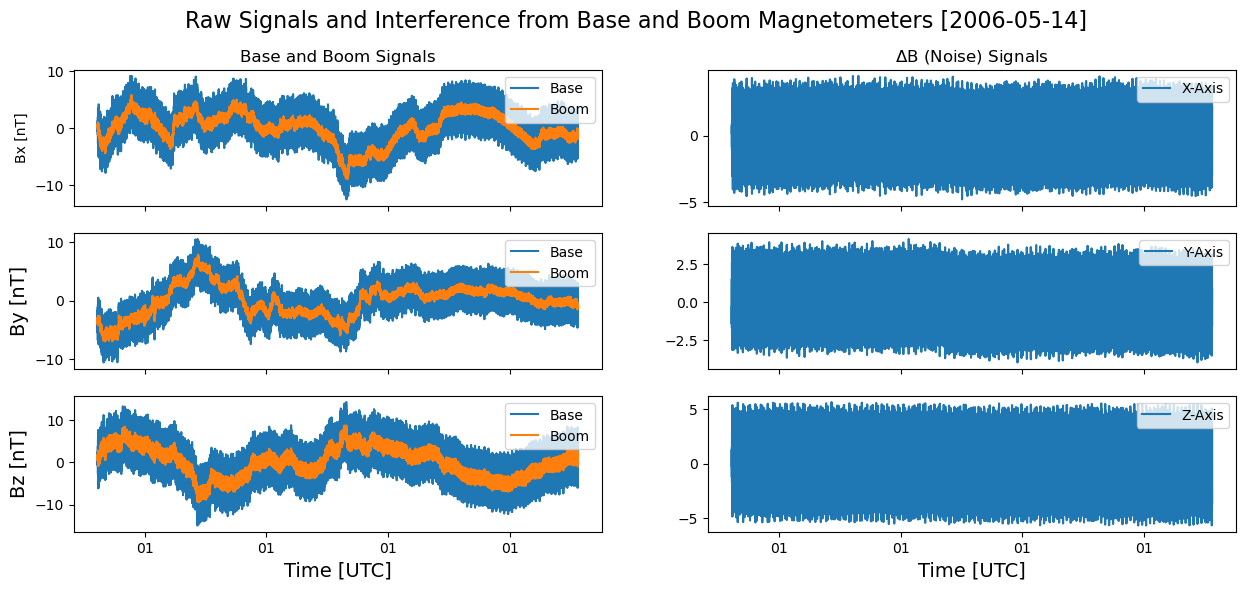

In [4]:
"Create a 3 x 2-panel plot of MAM-S1 and MAM-S2 data with overlapping magnetometers in the same panel"
fig, axs = plt.subplots(3, 2, figsize=(15, 6), sharex=True)

fig.suptitle("Raw Signals and Interference from Base and Boom Magnetometers [2006-05-14]", fontsize=16)
axs[0,0].set_title("Base and Boom Signals")
axs[0,0].plot(t, B[0,0], label="Base")
axs[0,0].plot(t, B[1,0], label="Boom")
axs[0,0].set_ylabel("Bx [nT]")
axs[0,0].legend(loc="upper right")

axs[1,0].plot(t, B[0,1], label="Base")
axs[1,0].plot(t, B[1,1], label="Boom")
axs[1,0].set_ylabel("By [nT]", fontsize=14)
axs[1,0].legend(loc="upper right")

axs[2,0].plot(t, B[0,2], label="Base")
axs[2,0].plot(t, B[1,2], label="Boom")
axs[2,0].set_xlabel("Time [UTC]", fontsize=14)
axs[2,0].set_ylabel("Bz [nT]", fontsize=14)
axs[2,0].legend(loc="upper right")

axs[0,1].set_title("$\Delta$B (Noise) Signals")
axs[0,1].plot(t, B[1,0]-B[0,0], label="X-Axis")
axs[0,1].legend(loc="upper right")

axs[1,1].plot(t, B[1,1]-B[0,1], label="Y-Axis")
axs[1,1].legend(loc="upper right")

axs[2,1].plot(t, B[1,2]-B[0,2], label="Z-Axis")
axs[2,1].set_xlabel("Time [UTC]", fontsize=14)
axs[2,1].legend(loc="upper right")

import matplotlib.dates as mdates

# After creating the subplots
for ax in axs.flat:
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

plt.show()



Find Coupling Coefficients

In [5]:
from algorithms import RAMEN
from scipy.stats import pearsonr
import importlib
importlib.reload(RAMEN)

axis = 2
RAMEN.fs = 128
RAMEN.weights = np.geomspace(1,.1,B.shape[0])
RAMEN.sspTol = 1
RAMEN.flip = False

result_ramen = RAMEN.clean(np.copy(B[:,axis]), triaxial=False)

print(pearsonr(result_ramen, noise[axis])[0])
print(pearsonr(B[1,axis], noise[axis])[0])
print(RAMEN.aii)

-0.05206788097435716
-0.22827699770374593
[[1.         1.        ]
 [1.         5.22698565]]


c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\algorithms\RAMEN.py:123: RuntimeWarning: invalid value encountered in divide
  alpha_ij = np.nanmean(np.abs(B_filtered[i]) / np.abs(B_filtered[0]), axis=-1)


In [6]:
from algorithms import WAICUPV2
importlib.reload(WAICUPV2)
WAICUPV2.fs = 1
WAICUPV2.uf=5000
WAICUPV2.detrend = True
WAICUPV2.weights = np.geomspace(1,.1,B.shape[0])
WAICUPV2.gain_method = 'sheinker'
WAICUPV2.sspTol = 1
WAICUPV2.flip = False
result_waicup = WAICUPV2.clean(np.copy(B[:,axis]), triaxial=False)
print(pearsonr(result_waicup, noise[axis])[0])
print(pearsonr(B[-1,axis], noise[axis])[0])

c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\algorithms\WAICUPV2.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  w_clean[s] = HOG(wn[:,s,:])


-0.0015015121204478192
-0.22827699770374593


In [7]:
from algorithms import HOG
importlib.reload(HOG)

HOG.fs = .1
HOG.weights = np.geomspace(10,.1,B.shape[0])
HOG.sspTol = 14
HOG.gain_method = 'sheinker'
HOG.flip = True
result_hog= HOG.clean(np.copy(B[:,axis]), triaxial=False)
print(pearsonr(result_hog, noise[axis])[0])
print(pearsonr(B[-1,axis], noise[axis])[0])
print(HOG.aii)

c:\Users\alexp\anaconda3\lib\site-packages\pymssa\mssa.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


-0.17524928213105673
-0.22827699770374593
[[ 1.          1.        ]
 [ 1.         14.64951259]]


In [8]:
from algorithms import UBSS
importlib.reload(UBSS)


UBSS.sigma = 1         
UBSS.sspTol = 15         # SSP Filter Threshold
UBSS.bpo = 2            # Number of Bands Per Octave in the NSGT Transform
UBSS.fs = 128              # Sampling Frequency
UBSS.boom = 0         # Index of boom magnetometer in (n_sensors, axes, n_samples) array
UBSS.cs_iters = 1        # Number of Iterations for Compressive Sensing
result_ubss= UBSS.clean(np.copy(B[:,axis]), triaxial=False)
print(pearsonr(result_ubss, noise[axis])[0])
print(pearsonr(B[-1,axis], noise[axis])[0])

c:\Users\alexp\anaconda3\lib\site-packages\nsgt\nsgfwin_sl.py:64: UserWarning: Q-factor too high for frequencies 0.03,0.05,0.07,0.09
  warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))
c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\algorithms\UBSS.py:222: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  B = np.vstack((np.hstack(B[i]) for i in range(magnetometers)))
c:\Users\alexp\anaconda3\lib\site-packages\nsgt\nsgfwin_sl.py:64: UserWarning: Q-factor too high for frequencies 0.03,0.05,0.07,0.09
  warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))
c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\algorithms\UBSS.py:279: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for n

-0.3058529865459317
-0.22827699770374593


In [9]:
"Take Continuous Wavelet Transform"
import fcwt
fs= 128  # Hz
f0 = 1  # Hz
f1 = fs / 2  # Hz

# take transform of B_kplo Z-axis
freqs_michibiki, out_michibiki= fcwt.cwt(B[1,axis], fs, f0, f1, fn=300, scaling='linear', nthreads=12)
freqs_michibiki = np.flip(freqs_michibiki)

# take transform of WAICUP Z-axis
_, out_ramen = fcwt.cwt(result_ubss, fs, f0, f1, fn=300, scaling='linear', nthreads=12)

# take transform of B_kplo Z-axis
_, out_noise = fcwt.cwt(noise[axis], fs, f0, f1, fn=300, scaling='linear', nthreads=12)

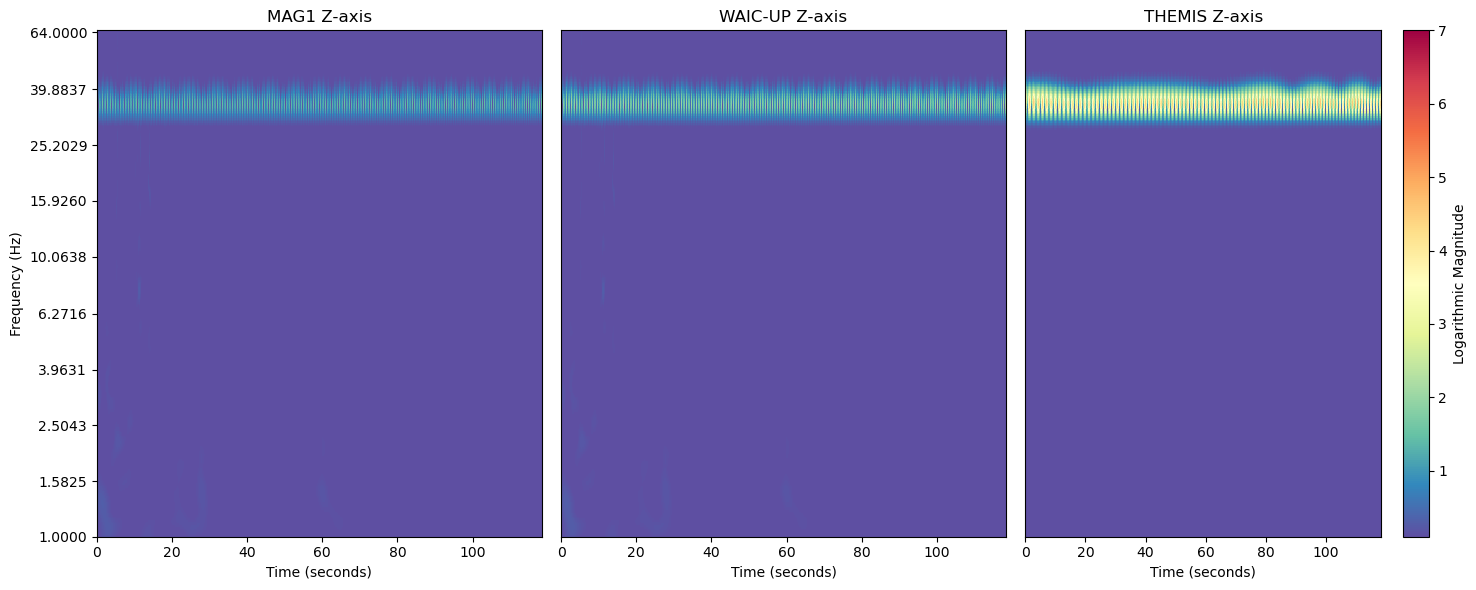

In [10]:

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
extent = [0, out_michibiki.shape[1] / fs, 0, out_michibiki.shape[0]]
cax1 = axs[0].imshow(np.abs(out_michibiki), aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0.1, vmax=7)
cax2 = axs[1].imshow(np.abs(out_ramen), aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0.1, vmax=7)
cax3 = axs[2].imshow(np.abs(out_noise), aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0.1, vmax=7)

#fig.colorbar(cax1, ax=axs[0], label='Logarithmic Magnitude')
#fig.colorbar(cax2, ax=axs[1], label='Logarithmic Magnitude')
fig.colorbar(cax3, ax=axs[2], label='Logarithmic Magnitude')

yticks_kplo = np.linspace(0, len(freqs_michibiki) - 1, 10).astype(int)
yticklabels_kplo = [f"{freqs_michibiki[i]:.4f}" for i in yticks_kplo]

axs[0].set_yticks(yticks_kplo)
axs[0].set_yticklabels(yticklabels_kplo)
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_title("MAG1 Z-axis")

# TURN OFF YTICKS FOR AXS[1] AND AXS[2]
axs[1].set_yticks([])
axs[1].set_xlabel('Time (seconds)')
axs[1].set_title("WAIC-UP Z-axis")
axs[2].set_yticks([])
axs[2].set_xlabel('Time (seconds)')
axs[2].set_title("THEMIS Z-axis")


plt.tight_layout()
plt.show()


C:\Users\alexp\AppData\Local\Temp\ipykernel_14368\3692697717.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(yticklabels_kplo)


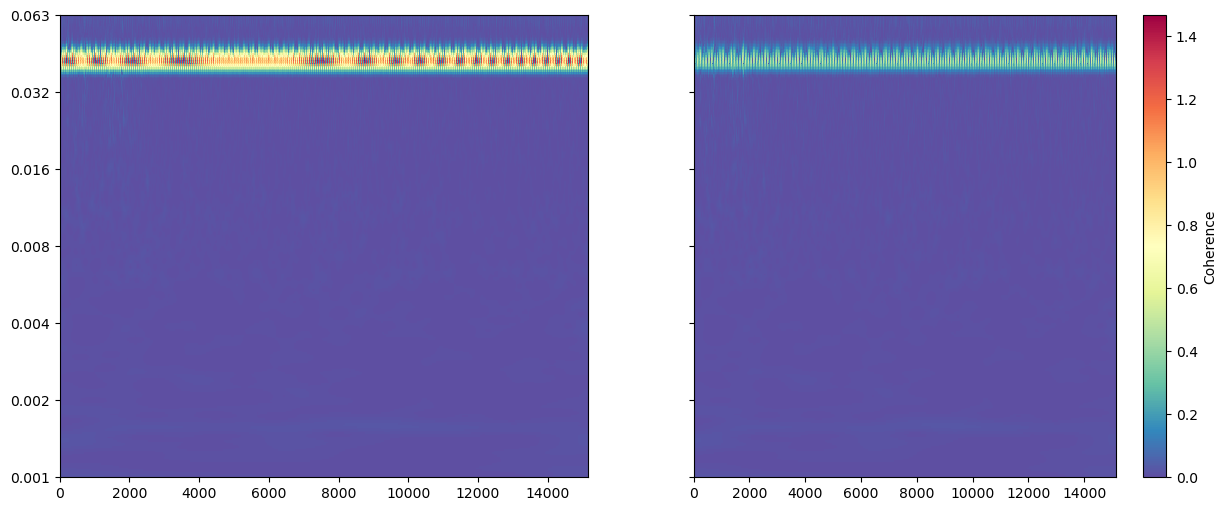

In [ ]:
b_coherence = np.abs(out_michibiki*np.conj(out_noise)) / (np.abs(out_michibiki)**2+ np.abs(out_noise)**2)**.5
r_coherence = np.abs(out_ramen*np.conj(out_noise)) / (np.abs(out_ramen)**2 + np.abs(out_noise)**2)**.5
vmax =  np.max([np.abs(b_coherence), np.abs(r_coherence)])

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
extent = [0, b_coherence.shape[1] / fs, 0, b_coherence.shape[0]]
cax1 = axs[0].imshow(b_coherence, aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0, vmax=vmax)
cax2 = axs[1].imshow(r_coherence, aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0, vmax=vmax)
axs[0].set_yticklabels(yticklabels_kplo)
axs[1].set_yticklabels([])
yticks_kplo = np.linspace(0, len(freqs_michibiki) - 1, 10).astype(int)
yticklabels_kplo = [f"{freqs_michibiki[i]:.3f}" for i in yticks_kplo]
fig.colorbar(cax2, ax=axs[1], label='Coherence')


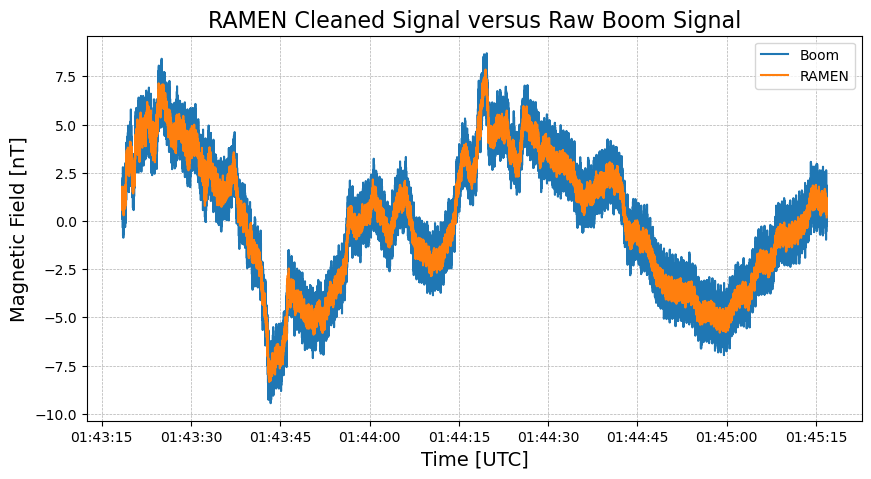

<Figure size 640x480 with 0 Axes>

In [41]:
# Make 3,1 subplot and overlay swarm on each result. Set location of each title to within the plot
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
#axs[0].plot(B[0,axis], label = 'M0')
axs.plot(t,B[-1,axis], label = 'Boom')
axs.plot(t, result_ramen, label = 'RAMEN')
axs.set_title("RAMEN Cleaned Signal versus Raw Boom Signal", y=1.0, fontsize=16)
axs.set_xlabel("Time [UTC]", fontsize=14)
axs.set_ylabel("Magnetic Field [nT]", fontsize=14)
axs.grid(True, which='both', linestyle='--', linewidth=0.5)
axs.legend()
plt.show()
plt.tight_layout()

In [102]:
"Take Continuous Wavelet Transform"
import fcwt
fs= 1  # Hz
f0 = 0.001  # Hz
f1 = 1 / 2  # Hz

# take transform of B_kplo Z-axis
freqs_michibiki, out_michibiki= fcwt.cwt(B[1,axis], fs, f0, f1, fn=300, scaling='linear', nthreads=12)
freqs_michibiki = np.flip(freqs_michibiki)

# take transform of WAICUP Z-axis
_, out_ramen = fcwt.cwt(result_ramen, fs, f0, f1, fn=300, scaling='linear', nthreads=12)

# take transform of B_kplo Z-axis
_, out_noise = fcwt.cwt(noise[axis], fs, f0, f1, fn=300, scaling='linear', nthreads=12)

In [103]:
print(np.max(np.abs(out_michibiki)), np.max(np.abs(out_ramen)), np.max(np.abs(out_noise)))

1.5476295 0.6903329 4.672742


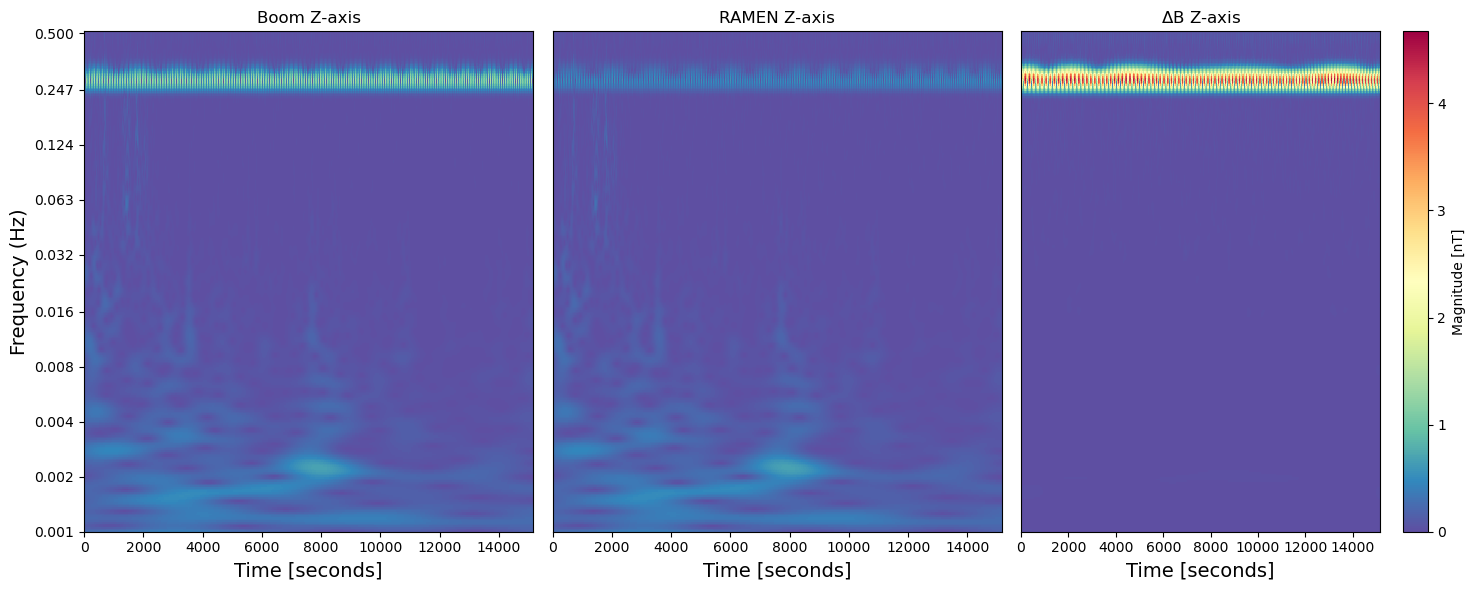

In [104]:

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
extent = [0, out_michibiki.shape[1] / fs, 0, out_michibiki.shape[0]]
vmax =  np.max([np.abs(out_michibiki), np.abs(out_ramen), np.abs(out_noise)])
cax1 = axs[0].imshow(np.abs(out_michibiki), aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0, vmax=vmax)
cax2 = axs[1].imshow(np.abs(out_ramen), aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0, vmax=vmax)
cax3 = axs[2].imshow(np.abs(out_noise), aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0, vmax=vmax)

#fig.colorbar(cax1, ax=axs[0], label='Logarithmic Magnitude')
#fig.colorbar(cax2, ax=axs[1], label='Logarithmic Magnitude')
fig.colorbar(cax3, ax=axs[2], label='Magnitude [nT]')

yticks_kplo = np.linspace(0, len(freqs_michibiki) - 1, 10).astype(int)
yticklabels_kplo = [f"{freqs_michibiki[i]:.3f}" for i in yticks_kplo]

axs[0].set_yticks(yticks_kplo)
axs[0].set_yticklabels(yticklabels_kplo)
axs[0].set_xlabel('Time [seconds]', fontsize=14)
axs[0].set_ylabel('Frequency (Hz)', fontsize=14)
axs[0].set_title("Boom Z-axis")

# TURN OFF YTICKS FOR AXS[1] AND AXS[2]
axs[1].set_yticks([])
axs[1].set_xlabel('Time [seconds]', fontsize=14)
axs[1].set_title("RAMEN Z-axis")
axs[2].set_yticks([])
axs[2].set_xlabel('Time [seconds]', fontsize=14)
axs[2].set_title("$\Delta$B Z-axis")


plt.tight_layout()
plt.show()


C:\Users\alexp\AppData\Local\Temp\ipykernel_14368\3692697717.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(yticklabels_kplo)


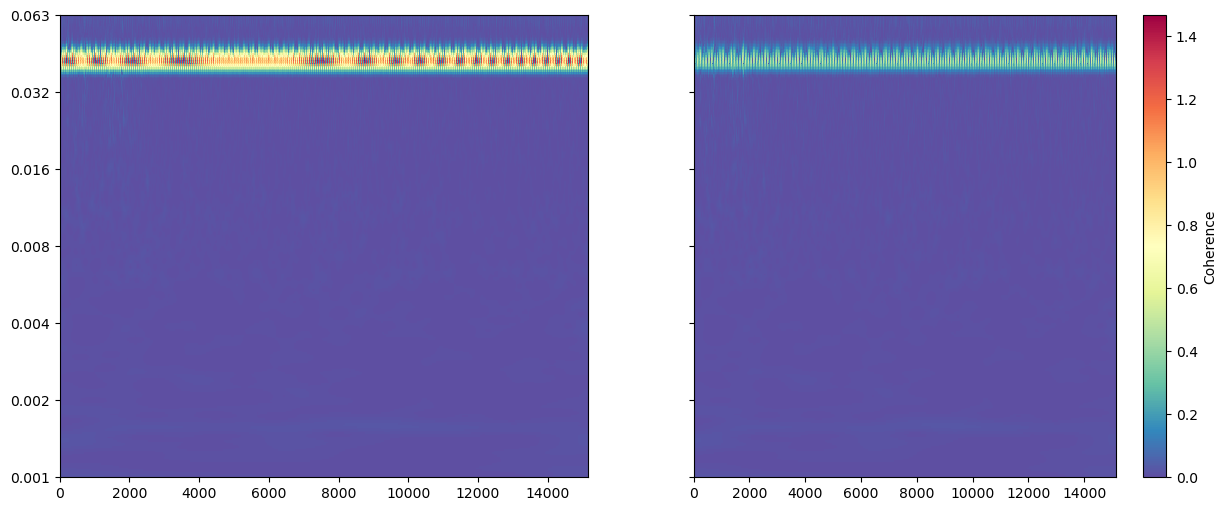

In [106]:
b_coherence = np.abs(out_michibiki*np.conj(out_noise)) / (np.abs(out_michibiki)**2+ np.abs(out_noise)**2)**.5
r_coherence = np.abs(out_ramen*np.conj(out_noise)) / (np.abs(out_ramen)**2 + np.abs(out_noise)**2)**.5
vmax =  np.max([np.abs(b_coherence), np.abs(r_coherence)])

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
extent = [0, b_coherence.shape[1] / fs, 0, b_coherence.shape[0]]
cax1 = axs[0].imshow(b_coherence, aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0, vmax=vmax)
cax2 = axs[1].imshow(r_coherence, aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0, vmax=vmax)
axs[0].set_yticklabels(yticklabels_kplo)
axs[1].set_yticklabels([])
yticks_kplo = np.linspace(0, len(freqs_michibiki) - 1, 10).astype(int)
yticklabels_kplo = [f"{freqs_michibiki[i]:.3f}" for i in yticks_kplo]
fig.colorbar(cax2, ax=axs[1], label='Coherence')


In [49]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def cross_spectral_coherence(x, y, fs, nperseg=256, noverlap=None):
    f, t, Cxy = signal.spectrogram(x, fs=fs, nperseg=nperseg, noverlap=noverlap, mode='complex')
    _, _, Cyy = signal.spectrogram(y, fs=fs, nperseg=nperseg, noverlap=noverlap, mode='complex')
    
    coherence = np.abs(Cxy)**2 / (np.abs(Cxy)**2 * np.abs(Cyy)**2)
    return f, t, coherence

# Assuming out_michibiki, out_ramen, and out_noise are your 2D arrays
fs = 1  # Hz (as given in your initial code)

# Calculate coherence
f, t, b_coherence = cross_spectral_coherence(out_michibiki, out_noise, fs)
_, _, r_coherence = cross_spectral_coherence(out_ramen, out_noise, fs)

print(b_coherence.shape)

c:\Users\alexp\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1867: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
C:\Users\alexp\AppData\Local\Temp\ipykernel_14368\3015333958.py:9: RuntimeWarning: divide by zero encountered in divide
  coherence = np.abs(Cxy)**2 / (np.abs(Cxy)**2 * np.abs(Cyy)**2)
C:\Users\alexp\AppData\Local\Temp\ipykernel_14368\3015333958.py:9: RuntimeWarning: invalid value encountered in divide
  coherence = np.abs(Cxy)**2 / (np.abs(Cxy)**2 * np.abs(Cyy)**2)


(300, 256, 67)
